### DOPASOWANIE WIELOSEKWENCYJNE (MSA - MULTIPLE SEQUENCE ALIGNMENT)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import requests as r
from io import StringIO
from Bio import SeqIO
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
import itertools

#### Wczytanie sekwencji z pliku w formacie FASTA 

In [32]:
def open_file(path):
    """
    Opens a file at the specified path and extracts protein sequences from it.

    Args:
        path (str): The path to the file containing the sequences.

    Returns:
        list or None: A list of extracted sequences if they are valid and follow the correct format, 
                      otherwise None.

    Raises:
        FileNotFoundError: If the specified file does not exist.
        ValueError: If the file format is incorrect or a sequence contains illegal characters.
    """
    if os.path.isfile(path):
        with open(path, 'r') as f:
            lines = f.readlines()
            seqs = []
            current_seq = ""
            for line in lines:
                if line.startswith(">"):
                    if current_seq:
                        seqs.append(current_seq)
                        current_seq = ""
                else:
                    current_seq += line.strip()
            if current_seq: 
                seqs.append(current_seq)
                
            for seq in seqs:
                allowed = '^[ACDEFGHIKLMNPQRSTUVWY]+$'
                if not re.fullmatch(allowed, seq):
                    raise ValueError("There are illegal characters in the sequence")
                    
            return seqs
    else:
        raise FileNotFoundError("File does not exist")


#### Zainicjonowanie macierzy, której pierwszy wiersz i pierwsza kolumna są odpowiednio wypełnione karą za przerwę

In [33]:
def initialize_matrix(seq1, seq2, gap):
    """
    Initializes a matrix for sequence alignment.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        gap (int or float): The gap penalty.

    Returns:
        numpy.ndarray: A matrix initialized for sequence alignment,
            with dimensions (len(seq1) + 1) x (len(seq2) + 1).
            The first row and column represent gap penalties.

    """
    n = len(seq1)
    m = len(seq2)
    mat = np.zeros((n + 1, m + 1))
    mat_back = np.zeros((n + 1, m + 1))

    for i in range(1, n + 1):
        mat[i, 0] = mat[i - 1, 0] + gap
    for j in range(1, m + 1):
        mat[0, j] = mat[0, j - 1] + gap

    return mat, mat_back


#### Wypełnianie macierzy odpowiednią punktacją oraz stworzenie macierzy z oznaczeniem ścieżki

In [34]:
def fill_matrix(seq1, seq2, gap, win, pun):
    """
    Fills a matrix for sequence alignment and constructs a backtracking matrix.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        gap (int or float): The gap penalty.
        win (int or float): The score for a match.
        pun (int or float): The score for a mismatch.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: A tuple containing:
            - The filled matrix for sequence alignment.
            - The backtracking matrix indicating the path of alignment.

    """
    directions = {"U": 1, "L": 2, "D": 3}
    mat, mat_back = initialize_matrix(seq1, seq2, gap)
    n, m = mat.shape

    for i in range(1, n):
        for j in range(1, m):
            match = mat[i - 1, j - 1] + (win if seq1[i - 1] == seq2[j - 1] else pun)
            mat[i, j] = max(mat[i - 1, j] + gap, mat[i, j - 1] + gap, match)

            if mat[i, j] == mat[i - 1, j] + gap:
                mat_back[i, j] = directions["U"]
            elif mat[i, j] == mat[i, j - 1] + gap:
                mat_back[i, j] = directions["L"]
            else:
                mat_back[i, j] = directions["D"]

    return mat, mat_back


#### Odpowiednie wypełnianie sekwencji dopasowania

In [35]:
def traceback_alignment(seq1, seq2, mat_back, gap):
    """
    Performs traceback on a filled matrix to obtain aligned sequences.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        mat_back (numpy.ndarray): The backtracking matrix obtained from sequence alignment.
        gap (int or float): The gap penalty.

    Returns:
        Tuple[str, str]: A tuple containing the aligned sequences.

    """
    
    dict = {"U": 1, "L": 2, "D": 3}
    seq1_aligned = []
    seq2_aligned = []
    n, m = mat_back.shape
    i, j = n - 1, m - 1

    while i > 0 or j > 0:
        if mat_back[i, j] == dict["D"]:
            seq1_aligned.append(seq1[i-1])
            seq2_aligned.append(seq2[j-1])
            i -= 1
            j -= 1
        elif mat_back[i, j] == dict["U"]:
            seq1_aligned.append(seq1[i-1])
            seq2_aligned.append('-')
            i -= 1
        elif mat_back[i, j] == dict["L"]:
            seq1_aligned.append('-')
            seq2_aligned.append(seq2[j-1])
            j -= 1

    return ''.join(seq1_aligned[::-1]), ''.join(seq2_aligned[::-1])


#### Stworzenie macierzy punktacji

In [36]:
def create_matrix(seq1, seq2, gap, win, pun):
    """
    Creates and visualizes the Needleman-Wunsch scoring matrix, performs traceback, and calculates alignment statistics.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        gap (int or float): The gap penalty.
        win (int or float): The score for a match.
        pun (int or float): The score for a mismatch.

    Returns:
        Tuple[numpy.ndarray, str, str, float]: A tuple containing:
            - The final score in the matrix
    """
    mat, mat_back = fill_matrix(seq1, seq2, gap, win, pun)
    n, m = mat.shape
    return mat[n-1, m-1]

#### Wyznaczenie dopasowanych sekwnencji

In [37]:
def alignment(seq1, seq2, gap, win, pun):
    """
    Aligns two sequences using the Needleman-Wunsch algorithm.

    Args:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        gap (int or float): The gap penalty.
        win (int or float): The score for a match.
        pun (int or float): The score for a mismatch.

    Returns:
        Tuple[str, str]: A tuple containing the aligned sequences.
            The first element is the aligned version of seq1,
            and the second element is the aligned version of seq2.
    """
    
    
    mat, mat_back = fill_matrix(seq1, seq2, gap, win, pun)
    seq1_aligned, seq2_aligned = traceback_alignment(seq1, seq2, mat_back, gap)
    return seq1_aligned, seq2_aligned

#### WYznaczenie sekwencji centralnej 

In [38]:
def central_seq(seqs):
    """
    Calculates the alignment scores for all pairs of sequences and stores them in a DataFrame with a sum column.
    Returns the sequence with the highest sum of alignment scores.

    Args:
        seqs (list of str): The list of sequences.

    Returns:
        Tuple[pd.DataFrame, str]: A tuple containing:
            - The DataFrame with the pairwise alignment scores and the sum of each row in the last column.
            - The sequence with the highest sum of alignment scores.
    """
    names = []
    length = len(seqs)
    for i in range(length):
        name = 'seq' + str(i + 1)
        names.append(name)
    names.append('sum')

    df = pd.DataFrame(columns=names, index=names[:-1])

    for i, j in itertools.combinations(range(length), 2):
        score = create_matrix(seqs[i], seqs[j], -2, 1, -1)
        df.iloc[i, j] = score
        df.iloc[j, i] = score
    
    df.fillna(0, inplace=True) 
    df['sum'] = df.sum(axis=1) 
    
    for i in range(length):
        df.iloc[i, i] = np.nan
    
    max_sum_index = df['sum'].idxmax()  
    central_sequence_index = int(max_sum_index[3:]) - 1  
    central_sequence = seqs[central_sequence_index]  

    return df, central_sequence

In [39]:
print(central_seq(['ATTGCCATT', 'ATGGCCATT', 'ATCCATTTTT', 'ATCTTCTT', 'ACTGACC']))

(      seq1  seq2  seq3  seq4  seq5   sum
seq1   NaN   7.0  -3.0   0.0  -3.0   1.0
seq2   7.0   NaN  -3.0   0.0  -4.0   0.0
seq3  -3.0  -3.0   NaN   2.0  -7.0 -11.0
seq4   0.0   0.0   2.0   NaN  -3.0  -1.0
seq5  -3.0  -4.0  -7.0  -3.0   NaN -17.0, 'ATTGCCATT')


C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


#### Porównanie sekwencji za pomocą algorytmu MSA „na gwiazdę” 

In [40]:
def center_star_alignment(seqs, gap, win, pun):
    """
    Aligns sequences to a central sequence using the center-star method.

    Args:
        seqs (list of str): List of sequences to be aligned.
        gap (int or float): Gap penalty.
        win (int or float): Score for a match.
        pun (int or float): Score for a mismatch.

    Returns:
        dict: A dictionary containing the aligned sequences, where keys are sequence names
              and values are their aligned representations.
              
    Writes:
        A file 'msa.txt' containing:
            - Parameters: gap, win, pun.
            - Original sequences.
            - Aligned sequences.
    """
    
    df, central = central_seq(seqs.copy())
    seqs_aligned = []
    final_alignment = {seq: list(seq) for seq in seqs}
    
    seqs.remove(central)
    
    for seq in seqs:
        seq1_aligned, seq2_aligned = alignment(central, seq, gap, win, pun)
        seqs_aligned.append((seq1_aligned, seq2_aligned))

        for i in range(len(seq1_aligned)):
            if seq1_aligned[i] == '-':
                for other_seq in final_alignment:
                    if other_seq != central and other_seq != seq:
                        final_alignment[other_seq].insert(i, '-')
        
        final_alignment[central] = list(seq1_aligned)
        final_alignment[seq] = list(seq2_aligned)
    
    final_alignment = {k: ''.join(v) for k, v in final_alignment.items()}
    
    max_length = max(len(seq) for seq in final_alignment.values())
    for k in final_alignment:
        final_alignment[k] += '-' * (max_length - len(final_alignment[k]))
    
    with open('msa.txt', 'a') as file:
        file.write(f"\nParameters: gap={gap}, win={win}, pun={pun}\n\n")
        file.write("Original Sequences:\n")
        for seq in seqs:
            file.write(f"{seq}\n")
        file.write("\nAligned Sequences:\n")
        for key, value in final_alignment.items():
            file.write(f"{key}: {value}\n")
   
    return final_alignment

In [41]:
sequences = ['ATTGCCATT', 'ATGGCCATT', 'ATCCATTTTT', 'ATCTTCTT', 'ACTGACC']
gap, win, pun = [-10, 10, 10]
alignment_result = center_star_alignment(sequences, gap, win, pun)
print("\n".join(alignment_result.values()))

ATTGCCATT-
ATGGCCATT-
ATCCATTTTT
ATCTTCTT--
ACTGACC---


C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


#### Graficzne wyświetlenie dopasowania

In [42]:
def graphic_representation(seqs, gap, win, pun, cell_width=1, cell_height=0.5):
    """
    Generates a graphical representation of aligned sequences using a heatmap.

    Args:
        seqs (list of str): List of sequences to be aligned.
        gap (int or float): Gap penalty.
        win (int or float): Score for a match.
        pun (int or float): Score for a mismatch.
        cell_width (int or float, optional): Width of each cell in the heatmap. Defaults to 1.
        cell_height (int or float, optional): Height of each cell in the heatmap. Defaults to 0.5.

    Returns:
        None
    """
    
    
    sequences_aligned = center_star_alignment(seqs, gap, win, pun)
    aminoacids = {
            "A": 1,
            "C": 2,
            "D": 3,
            "E": 4,
            "F": 5,
            "G": 6,
            "H": 7,
            "I": 8,
            "-": 9,
            "K": 0,
            "L": 10,
            "M": 11,
            "N": 12,
            "P": 13,
            "Q": 14,
            "R": 15,
            "S": 16,
            "T": 17,
            "V": 18,
            "W": 19,
            "Y": 20,      
        }
    seq_matrix = []
    seq_annotations = []
    for seq in sequences_aligned.values():
        seq_values = [aminoacids[aa] for aa in seq]
        seq_matrix.append(seq_values)
        seq_annotations.append(list(seq))
    
    seq_matrix = np.array(seq_matrix)
    y_labels = np.arange(len(seq_matrix), 0, -1).tolist()  

    num_sequences = len(seq_matrix)
    sequence_length = len(seq_matrix[0])

    fig_width = cell_width * sequence_length
    fig_height = cell_height * num_sequences

    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.heatmap(seq_matrix, annot=seq_annotations, fmt='', cmap="PiYG", cbar=False, linewidths=0.5, linecolor='black', xticklabels=False, yticklabels=y_labels, annot_kws={"color": "black", "size": 14})

    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(np.arange(0.5, sequence_length, 1))
    ax_top.set_xticklabels(np.arange(1, sequence_length + 1, 1))
    ax_top.set_xlabel('Sequence Position')
    
    plt.title(f'Aligned Sequences\nWin score:{win}, punishment score: {pun}, gap score: {gap}  ')
    plt.ylabel('Sequences')
    plt.show()


C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


MQPILLLV
MLR-LL--
MK-ILLL-
MPPVLILV


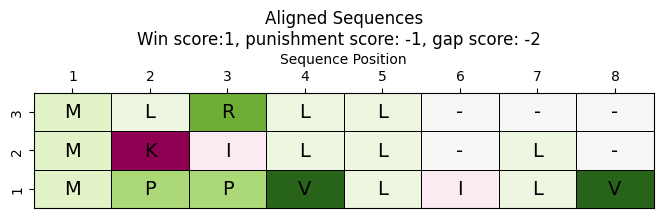

In [43]:
sequences = ['MQPILLLV', 'MLRLL', 'MKILLL', 'MPPVLILV']
gap, win, pun = [-2, 1, -1]
alignment_result = center_star_alignment(sequences, gap, win, pun)
print("\n".join(alignment_result.values()))
graphic_representation(sequences, gap, win, pun)

C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


ATTGCCATT-
ATGGCCATT-
ATCCATTTTT
ATCTTCTT--
ACTGACC---


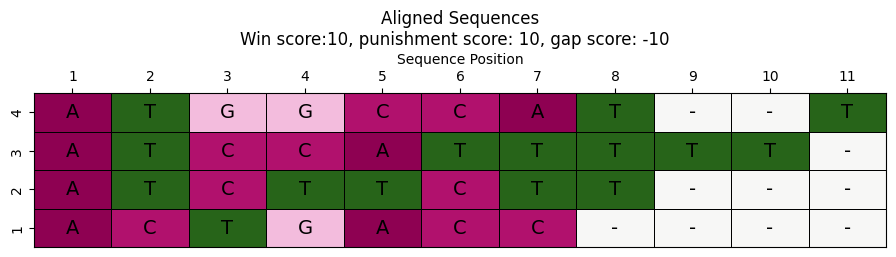

In [44]:
sequences = ['ATTGCCATT', 'ATGGCCATT', 'ATCCATTTTT', 'ATCTTCTT', 'ACTGACC']
gap, win, pun = [-10, 10, 10]
alignment_result = center_star_alignment(sequences, gap, win, pun)
print("\n".join(alignment_result.values()))
graphic_representation(sequences, gap, win, pun)

C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN
MAVWLQAGALLVLLVVSSVSTNPGTP-QHLCGSHLVDALYLVCGPTGFFYNPKRDVEPLLGFLPPKSAQETEVADFAFKDHAELIR-KRGIVEQCCHKPCSIFELQNYCN
MALWTRLRPLLALLALWPPPPARAFVNQHLCGSHLVEALYLVCGERGFFYTPKARREVEGPQVGALELAGGPGAGGL-----EGPPQKRGIVEQCCASVCSLYQLENY--
MALWMHLLTVLALLALWGPNTGQAFVSRHLCGSNLVETLYSVCQDDGFFYIPKDRRELEDPQVEQTELGMGLGAGGLQPLALEMALQKRGIVDQCCTGTCTRHQLQSYCN


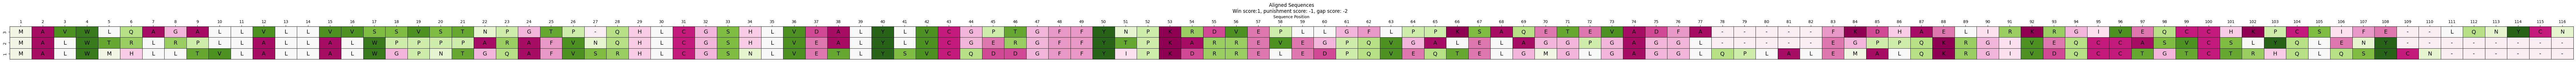

In [45]:
sequences = open_file("insulin.txt")
gap, win, pun = [-2, 1, -1]
alignment_result = center_star_alignment(sequences, gap, win, pun)
print("\n".join(alignment_result.values()))
graphic_representation(sequences, gap, win, pun)

C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
C:\Users\martu\AppData\Local\Temp\ipykernel_18196\3680395672.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


MALWMRLLP--L-LA--LL--ALWGPDPAAAFVN---------QH---LCGSH-LV-EALYLVCGERGFFYTPKTRREAEDLQVG---QV----ELGG-G--PGAG-SLQ-P--L------A-LEGSL------
MAGTV-LGVGAGVFILALLWVAVLLLCVLLSRAS-GAAR----FSVIFLFFGAVIITSVLLLFPRAGEFPAPEVEVKIVDDFFIG---RYVLLAFLSAIFLG--GLFLVLIH--YVL--EPI-YAKPL--HSY-
MSRHSRLQRQVLSLYRDLLRAGRGKPGAEARVRA-EFRQ----HAGLPRSDVLRIEYLYRRGRRQLQLLRSGHATAMGAFVRPRA---PTGEPGGVGCQPDDGDSPRNPHDS--TGA--PET-RPDGR------
MFRQCAK-RYASSLPPNALKPAFGPPDKVAAQKFKESLMATEKHAKDTSNMWVKISVWVALPAIALTAVNTYFVEKEHAEHREHLKHVPDSEWPRDYEFMNIRSKPFFWGDGDKTLFWNPVVNRHIEHDD----


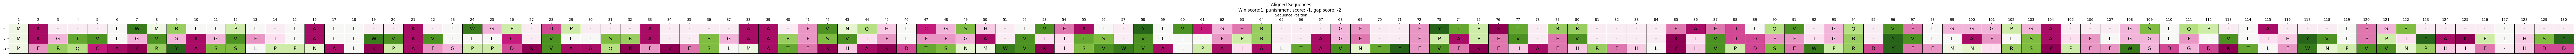

In [46]:
sequences = open_file("niepowiazane.txt")
gap, win, pun = [-2, 1, -1]
#print(center_star_alignment(seqs))
alignment_result = center_star_alignment(sequences, gap, win, pun)
print("\n".join(alignment_result.values()))
graphic_representation(sequences, gap, win, pun)